# Exploratory Data Analysis (EDA) for "Sequentially Comparing Statistical Postprocessing Methods for Weather Forecasts"

This notebook includes EDA plots for the ensemble forecast data from [Henzi and Ziegel (2021)](https://arxiv.org/abs/2103.08402).

Code/Data References:
- https://github.com/AlexanderHenzi/eprob/tree/master/replication_material
- https://github.com/AlexanderHenzi/isodistrreg

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

import comparecast as cc

cc.set_theme()

In [2]:
DATA_DIR = "eprob/replication_material/precip_fcs"
PLOTS_DIR = "plots/weather"
UPDATE_PLOTS = True

## Data & Forecasts

- The dataset is collected by Henzi et al. (2019), containing 24-hour accumulated precipitation (mm, integer-rounded) from 2007-01-06 to 2017-01-01 at meteorological stations on airports in London, Brussels, Zurich, and Frankfurt. 
- Covariates (initial forecasts) are the 52 members (1 high-resolution `hres` member, 1 control `ctr` member, and 50 perturbed members that are ensembled `ens`) of the NWP ensemble operated by the European Centre for Medium-Range Weather Forecasts (ECMWF; Molteni et al., 1996; Buizza et al., 2005) for days 1 to 5.
- We compare IDR, HCLR, and HCLR_ as three statistical postprocessing methods for predicting the [probability of precipitation (PoP)](https://www.weather.gov/ffc/pop) given these covariates. Each postprocessing method is fit to the first half of the dataset; we compare their performances on the second half for validation.

In [3]:
# forecasts generated by AlexanderHenzi/eprob
precip_fcs = cc.data_utils.weather.read_precip_fcs(DATA_DIR, pop_only=False)
precip_fcs

,airport,lag,date,obs,y,hres,ctr,ens,p1,p2,...,p47,p48,p49,p50,pop_hclr,pop_hclr_noscale,pop_idr,tail_hclr,tail_hclr_noscale,tail_idr
0,Brussels,1,2012-02-03,0.0,0,0.000000,0.001907,0.001679,0.001907,0.001907,...,0.001907,0.001907,0.001907,0.001907,0.071857,0.140121,0.00926,0.000035,0.000751,0.0
1,Brussels,1,2012-02-04,1.2,1,1.011240,1.038790,1.066457,1.201272,0.987589,...,0.686288,1.744449,0.517607,1.272619,0.760288,0.689796,0.61111,0.003086,0.009907,0.0
2,Brussels,1,2012-02-05,0.0,0,0.003889,0.002027,0.017981,0.050843,0.002027,...,0.002742,0.001967,0.001907,0.002623,0.108429,0.158243,0.00926,0.000083,0.000864,0.0
3,Brussels,1,2012-02-06,0.0,0,0.003728,0.002742,0.006876,0.001907,0.015736,...,0.002027,0.002623,0.011049,0.002027,0.090644,0.155276,0.00926,0.000046,0.000845,0.0
4,Brussels,1,2012-02-07,0.0,0,0.000000,0.001907,0.001407,0.002623,0.000024,...,0.000000,0.000000,0.000358,0.001907,0.071761,0.139129,0.00926,0.000035,0.000745,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6256,Zurich,1,2016-12-28,0.0,0,0.002616,0.003811,0.006565,0.003813,0.007837,...,0.000305,0.019908,0.003818,0.018039,0.104390,0.159549,0.07071,0.000128,0.001164,0.0
6257,Zurich,1,2016-12-29,0.0,0,0.007629,0.003826,0.004196,0.004074,0.003817,...,0.003810,0.007629,0.003815,0.003808,0.104510,0.164683,0.07071,0.000126,0.001210,0.0
6258,Zurich,1,2016-12-30,0.0,0,0.004679,0.000000,0.002970,0.003815,0.003813,...,0.003818,0.000000,0.003815,0.003560,0.104810,0.162935,0.04000,0.000127,0.001193,0.0
6259,Zurich,1,2016-12-31,0.0,0,0.009101,0.005722,0.006837,0.014912,0.008094,...,0.014924,0.004059,0.007831,0.002145,0.109351,0.168074,0.07071,0.000130,0.001239,0.0


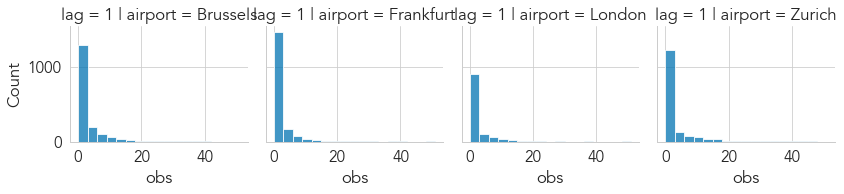

In [4]:
# observations
fg = sns.displot(precip_fcs, x="obs", row="lag", col="airport", binwidth=3, height=3)
if UPDATE_PLOTS:
    os.makedirs(PLOTS_DIR, exist_ok=True)
    fg.savefig(os.path.join(PLOTS_DIR, "precipitation.pdf"))

Note that the "true" output is a mixed discrete-continuous variable, with point mass at zero.

Following Henzi and Ziegel (2021), we focus on the "binary" task of forecasting the probability of precipitation (PoP) instead.

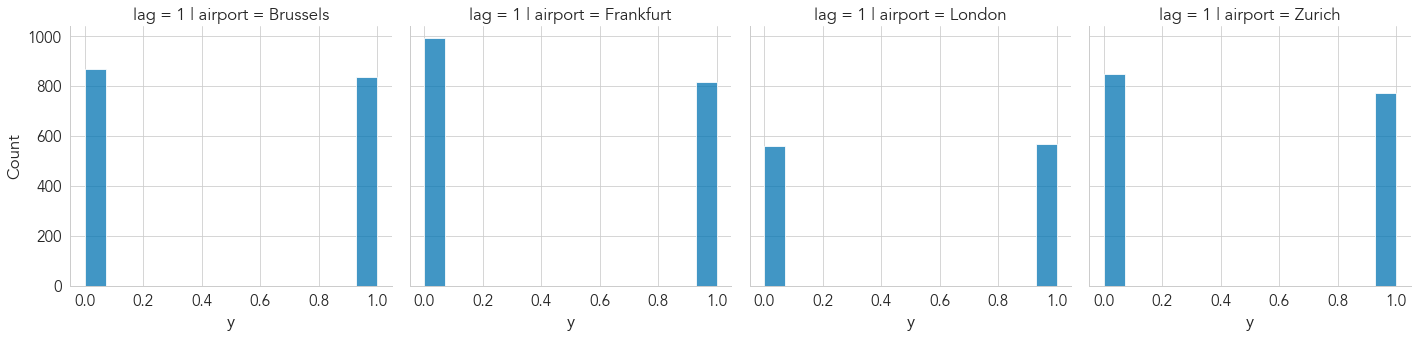

In [5]:
# PoP data (binary)
fg = sns.displot(x="y", row="lag", col="airport", data=precip_fcs)
if UPDATE_PLOTS:
    fg.savefig(os.path.join(PLOTS_DIR, "PoP.pdf"))

### Precipitation Forecasts (not tested in our experiments)

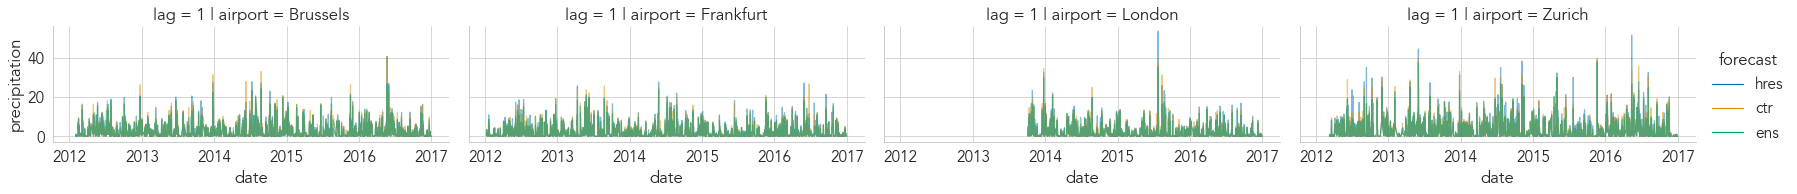

In [6]:
mdf = precip_fcs.melt(id_vars=["date", "airport", "lag"], 
                      value_vars=["hres", "ctr", "ens"],
                      var_name="forecast", value_name="precipitation")
fg = sns.relplot(x="date", y="precipitation", hue="forecast", kind="line", alpha=0.5, 
                 row="lag", col="airport", height=3, aspect=2, data=mdf)
None

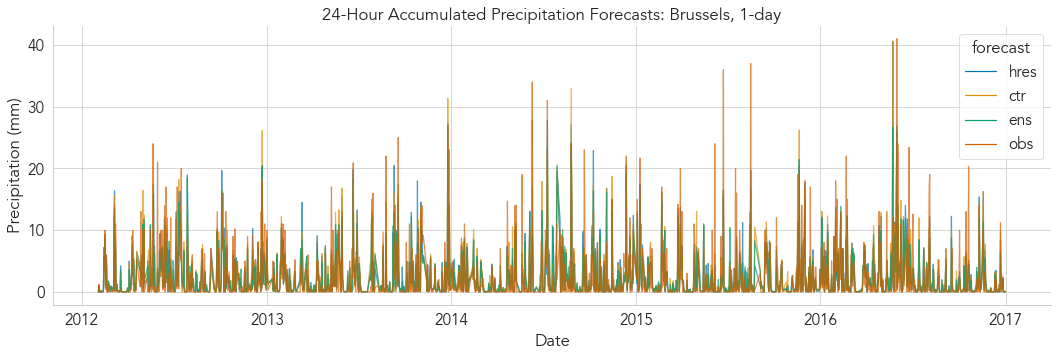

In [7]:
airport, lag = "Brussels", 1

df = precip_fcs[(precip_fcs["airport"] == airport) & (precip_fcs["lag"] == lag)].copy()
mdf = df.melt(id_vars=["date", "airport", "lag"], 
              value_vars=["hres", "ctr", "ens", "obs"],
              var_name="forecast", value_name="value")
fg = sns.relplot(x="date", y="value", kind="line", markers=True,
                 hue="forecast", alpha=0.7, 
                 height=5, aspect=3,
                 facet_kws={"legend_out": False},
                 data=mdf)
fg.set(
    xlabel="Date",
    ylabel="Precipitation (mm)",
    title=f"24-Hour Accumulated Precipitation Forecasts: {airport}, {lag}-day"
)
None

### PoP Forecasts (binary; used in our experiments)

In [8]:
pop_fcs = cc.data_utils.weather.read_precip_fcs(DATA_DIR, pop_only=True)
pop_fcs

,airport,lag,date,y,idr,hclr,hclr_noscale
0,Brussels,1,2012-02-03,0,0.00926,0.071857,0.140121
1,Brussels,1,2012-02-04,1,0.61111,0.760288,0.689796
2,Brussels,1,2012-02-05,0,0.00926,0.108429,0.158243
3,Brussels,1,2012-02-06,0,0.00926,0.090644,0.155276
4,Brussels,1,2012-02-07,0,0.00926,0.071761,0.139129
...,...,...,...,...,...,...,...
6256,Zurich,1,2016-12-28,0,0.07071,0.104390,0.159549
6257,Zurich,1,2016-12-29,0,0.07071,0.104510,0.164683
6258,Zurich,1,2016-12-30,0,0.04000,0.104810,0.162935
6259,Zurich,1,2016-12-31,0,0.07071,0.109351,0.168074


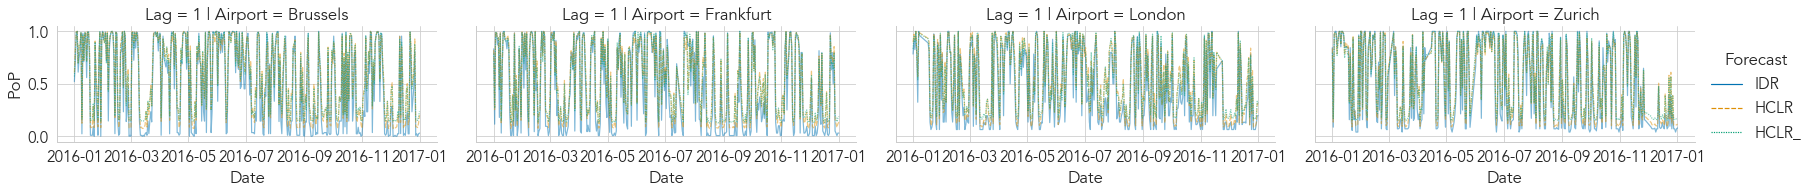

In [9]:
year = "2016"
pop_fcs_year = pop_fcs[pop_fcs.date >= year].copy()
pop_fcs_year.columns = ["Airport", "Lag", "Date", "Data", "IDR", "HCLR", "HCLR_"]
pop_fcs_year = pop_fcs_year.sort_values(["Airport", "Lag", "Date"], ascending=(True, True, True))
mdf = pop_fcs_year.melt(
    id_vars=["Date", "Airport", "Lag"], 
    value_vars=["IDR", "HCLR", "HCLR_"],
    var_name="Forecast", value_name="PoP")
ax = sns.relplot(x="Date", y="PoP", hue="Forecast", kind="line", 
                 style="Forecast", alpha=0.5, 
                 row="Lag", col="Airport", 
                 height=3, aspect=2,
                 data=mdf)
if UPDATE_PLOTS:
    ax.savefig(os.path.join(PLOTS_DIR, f"PoP_forecasts_{year}.pdf"))
None

Zoom in more closely to the final 3 months of the data at one location:

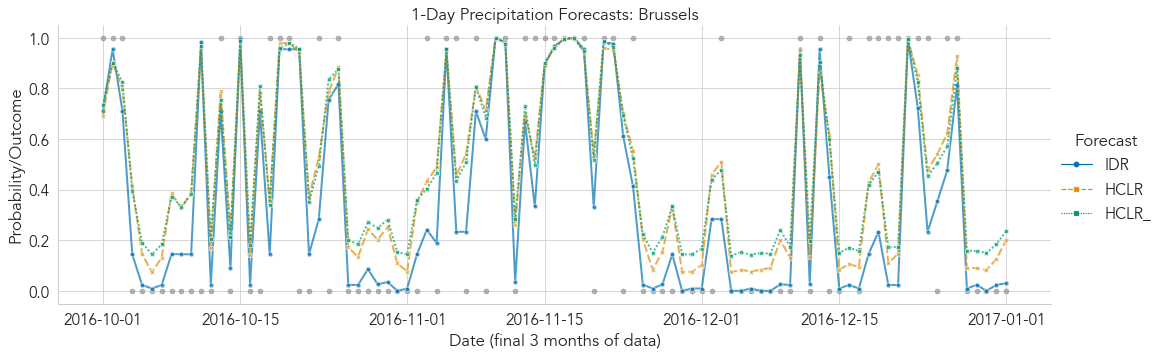

In [10]:
airport, lag, start_date = "Brussels", 1, "2016-10-01"

df = pop_fcs[(pop_fcs["airport"] == airport) & 
             (pop_fcs["lag"] == lag) & 
             (pop_fcs["date"] >= start_date)]
mdf = df.melt(
    id_vars=["date"], 
    value_vars=["idr", "hclr", "hclr_noscale"],
    var_name="Forecast", 
    value_name="PoP",
)
mdf["Forecast"] = mdf["Forecast"].map({
    "idr": "IDR", 
    "hclr": "HCLR", 
    "hclr_noscale": "HCLR_",
})

palette = cc.get_colors()
fg = sns.relplot(x="date", y="PoP", kind="line", linewidth=2,
                 hue="Forecast", style="Forecast", markers=True, 
                 palette=palette[:3], alpha=0.7, 
                 height=5, aspect=3,
                 data=mdf)
fg.axes[0][0].scatter(df.date, df.y, color=palette[7], 
                      alpha=0.7, marker="o", label="data")
fg.set(
    xlabel="Date (final 3 months of data)",
    ylabel="Probability/Outcome",
    title=f"{lag}-Day Precipitation Forecasts: {airport}",
)
if UPDATE_PLOTS:
    fg.savefig(os.path.join(PLOTS_DIR, f"PoP_forecasts_{year}_{airport}{lag}.pdf"))
None